## IRIS Task

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
setosaTrainingVec = []
versicolorTrainingVec = []
virginicaTrainingVec = []

setosaTestVec = []
versicolorTestVec = []
virginicaTestVec = []

TrainingSize = 30
TestSize = 20

with open('iris_data/class_1', 'r') as file:
    for line in file:
        if len(setosaTrainingVec) < TrainingSize:
            setosaTrainingVec.append([float(x) for x in line.split(',')])
        else:
            setosaTestVec.append([float(x) for x in line.split(',')])

with open('iris_data/class_2', 'r') as file:
    for line in file:
        if len(versicolorTrainingVec) < TrainingSize:
            versicolorTrainingVec.append([float(x) for x in line.split(',')])
        else:
            versicolorTestVec.append([float(x) for x in line.split(',')])

with open('iris_data/class_3', 'r') as file:
    for line in file:
        if len(virginicaTrainingVec) < TrainingSize:
            virginicaTrainingVec.append([float(x) for x in line.split(',')])
        else:
            virginicaTestVec.append([float(x) for x in line.split(',')])

In [10]:
#In order to properly implement w0 we need to extend the example data with 1(vector)
ones_vector_training = np.ones((TrainingSize, 1))
ones_vector_test = np.ones((TestSize, 1))

setosaTrainingVec = np.array(setosaTrainingVec)
versicolorTrainingVec = np.array(versicolorTrainingVec)
virginicaTrainingVec = np.array(virginicaTrainingVec)

# adding ones to training set
setosaTrainingVec = np.concatenate((setosaTrainingVec, ones_vector_training), axis=1)
versicolorTrainingVec = np.concatenate((versicolorTrainingVec, ones_vector_training), axis=1)
virginicaTrainingVec = np.concatenate((virginicaTrainingVec, ones_vector_training), axis=1)

setosaTestVec = np.array(setosaTestVec)
versicolorTestVec = np.array(versicolorTestVec)
virginicaTestVec = np.array(virginicaTestVec)

# adding ones to test set
setosaTestVec = np.concatenate((setosaTestVec, ones_vector_test), axis=1)
versicolorTestVec = np.concatenate((versicolorTestVec, ones_vector_test), axis=1)
virginicaTestVec = np.concatenate((virginicaTestVec, ones_vector_test), axis=1)

X = np.concatenate((setosaTrainingVec, versicolorTrainingVec, virginicaTrainingVec), axis=0)
X_test = np.concatenate((setosaTestVec, versicolorTestVec, virginicaTestVec), axis=0)

In [11]:
np.random.seed(42)

x = np.append(np.array([np.random.randint(-2,2) for i in range(4)]), 1)
W = np.random.uniform(-1, 1, (3,5)) # W is 3x4 and w0 is 3x1, together we get [W w0] -> W
T = np.concatenate((np.tile([1,0,0], (TrainingSize,1)), np.tile([0,1,0], (TrainingSize,1)), np.tile([0,0,1], (TrainingSize,1))))

def g(x, W): # Eq 20 on vector form classification compendium
    zk = np.matmul(W, x)
    gk = 1 / (1 + np.exp(-zk))
    return gk

print(g(x, W))

[0.66583558 0.57682654 0.57587511]


In [12]:
def MSE(X, T, W): # Eq 19 in classification compendium
    
    mseSum = 0
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        mseSum += (1/2)* np.linalg.norm((gk - tk), ord=2)
    
    return mseSum

def gradMSE(X, T, W): # Eq 22
    
    gradMSESum = np.zeros((3,5))
    
    for i in range(np.size(X, 0)):
        xk = X[i,:]
        tk = T[i,:]
        gk = g(xk, W)
        
        a = np.multiply((gk - tk), gk)
        b = np.multiply(a, np.ones(3).T - gk)

        gradMSESum += np.outer(b, xk)

    return gradMSESum

print(MSE(X, T, W))
print(gradMSE(X, T, W))

41.49937054835796
[[-1.56844111 -2.6637589   2.46003181  1.16682085 -0.58106419]
 [ 0.78590981  0.47866727  0.3840899   0.11332964  0.14880311]
 [ 9.68291571  8.56425953 -2.22837451 -1.90205383  2.35264238]]


## Linesearch

Step lenght determined by algorithm 3.1 in Numerical Optimization by N&W, Method of training is steepest descent

In [13]:
# Backtracking linesearch algorithm 3.1 (Not used)

alpha0 = 1
rho = 0.95
c = 10e-3

def backtrackingLineSearch(rho, c, Wk, pk):
    alpha = alpha0
    while MSE(X, T, (Wk + alpha*pk)) > MSE(X, T, Wk) + c * alpha * np.linalg.norm(np.matmul(pk.T, pk), ord='fro'):
        alpha = alpha * rho
    
    return alpha
    

In [22]:
tolerance = 1e-3
alpha1 = 0.2
alpha2 = 0.15
alpha3 = 0.0175

np.random.seed(10)
W_input = np.random.uniform(-1, 1, (3,5))
W_old_input = W_input + 10*np.ones((3,5))


W = W_input
iterations = 0
#Condition on grad W
while np.linalg.norm(gradMSE(X, T, W), ord='fro') > tolerance:
    W = W - alpha1 * gradMSE(X, T, W)
    iterations+=1
    #print(f"Norm: {np.linalg.norm(gradMSE(X, T, W), ord='fro')}, MSE: {MSE(X, T, W)}")

print(f"final MSE with condition on GradW: {MSE(X,T,W)}, after {iterations} number of iterations")
print(f"final norm of GradW with condition on GradW: {np.linalg.norm(gradMSE(X, T, W), ord='fro')}\n\n")

W = W_input
W_old = W_old_input
iterations = 0
#Condition on change in W
while np.linalg.norm(W-W_old, ord='fro') > tolerance:
    #print(f"Change in W: {np.linalg.norm(W-W_old, ord='fro')}, MSE: {MSE(X, T, W)}")
    W_old = W
    W = W - alpha2 * gradMSE(X, T, W)
    iterations +=1


print(f"final MSE with condition on GradW: {MSE(X,T,W)}, after {iterations} number of iterations")
print(f"final norm of DeltaMSE with condition on DeltaMSE: {np.linalg.norm(W-W_old, ord='fro')} \n\n")

W = W_input
W_old = W_old_input
iterations = 0
# Condition on MSE
while MSE(X, T, W) > 14.3:
    
    gradW = gradMSE(X,T,W)
    #print(f"Change in W1: {np.linalg.norm(W-W_old, ord='fro')}, MSE: {MSE(X, T, W)}")
    W_old = W
    W = W - alpha3 * gradW
    iterations +=1


print(f"final MSE with condition on GradW: {MSE(X,T,W)}, after {iterations} number of iterations")
print(f"final norm of DeltaMSE with condition on MSE: {np.linalg.norm(W-W_old, ord='fro')}")


final MSE with condition on GradW: 42.426451410167864, after 85 number of iterations
final norm of GradW with condition on GradW: 2.1518304750074185e-05


final MSE with condition on GradW: 42.426402762089324, after 185 number of iterations
final norm of DeltaMSE with condition on DeltaMSE: 1.652298124057606e-05 


final MSE with condition on GradW: 14.299981369938015, after 17576 number of iterations
final norm of DeltaMSE with condition on MSE: 0.20573887123332793


# Verification of model

[[20.  0.  0.]
 [ 0. 18.  2.]
 [ 0.  0. 20.]]


Text(0.5, 1.0, '30 first training / 20 last test')

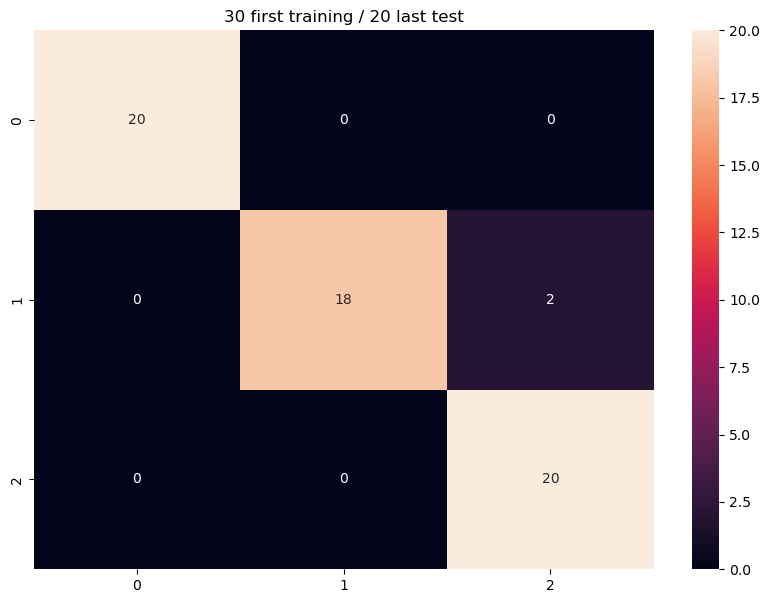

In [ ]:
import seaborn as sn

T_test = np.concatenate((np.tile([1,0,0], (TestSize,1)), np.tile([0,1,0], (TestSize,1)), np.tile([0,0,1], (TestSize,1))))

# x-axis: true class
# y-axis: predicted class
confMatrix = np.zeros((3,3))

for i in range(np.size(X_test, 0)):
    x = X_test[i, :]
    t = T_test[i, :]
    
    true_class = np.argmax(t)
    predicted_class = np.argmax(g(x, W))
    #print(true_class, np.argmax(g(x, W)))
    confMatrix[true_class][predicted_class] += 1

print(confMatrix)

plt.figure(figsize = (10,7))
sn.heatmap(confMatrix, annot=True).set_title('30 first training / 20 last test')
